In [1]:
## load packages 
import pandas as pd
import re
import numpy as np

## nltk imports
#!pip install nltk # can install on terminal or by uncommenting this line
#import nltk; nltk.download('punkt'); nltk.download('stopwords')
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt

## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer

## lda
#!pip install gensim # can install by uncommenting this line
from gensim import corpora
import gensim

## sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## visualizing LDA--likely need to install
#!pip install pyLDAvis # can install by uncommenting this line
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## random
import random
import string; punctlist = [char for char in string.punctuation] # list of english punctuation marks

In [2]:
import spacy
sp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()
import ast
import networkx as nx
import urllib, json
from itertools import combinations
from collections import Counter
from netwulf import visualize

## Load Data

In [3]:
tarte_df = pd.read_csv("/Users/giselle/Desktop/Dartmouth/Skinfluence/data/instagram_tarte.csv")
tarte_df.head()

,content_type,creation_time,hashtags,id,is_branded_content,lang,match_type,mcl_url,modified_time,multimedia,post_owner.type,post_owner.id,post_owner.name,post_owner.username,statistics.comment_count,statistics.like_count,statistics.views,statistics.views_date_last_refreshed,text
0,videos,2025-05-29T14:33:59+00:00,"[""cherrylips"",""target"",""tartecosmetics"",""tarte...",630864576671620,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T15:04:05+00:00,NaN,creator,1986316895165004,BEAUthiFUL,beauthiful,7.0,174.0,NaN,NaN,DAY 20 looking for Tarte cosmetics X Tru Fru c...
1,videos,2025-05-29T02:20:45+00:00,"[""vivo_mac_egypt"",""mac_cosmetics_vivo"",""vivo_d...",1782090792517094,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T11:10:51+00:00,"[{""id"":""1782090792517094"",""type"":""video"",""dura...",business,1900038944095416,vivo safwat,mac_cosmetics_egypt_vivo,0.0,1.0,284.0,2025-05-29,Shadows 😍❤️#tarte #mac_cosmetics_egypt_vivo #v...
2,videos,2025-05-28T17:28:14+00:00,NaN,1361459321801703,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-28T21:38:21+00:00,"[{""id"":""1361459321801703"",""type"":""video"",""dura...",business,627405113686188,Tag Ofashion,makeup_by_tagofashionn,0.0,5.0,621.0,2025-05-29,"This Set Contains:\n\n- 1.7 oz/ 50 mL Dae, Cac..."
3,videos,2025-05-28T15:37:26+00:00,"[""cherrylips"",""target"",""tartecosmetics"",""tarte...",1449743739979654,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-28T23:07:32+00:00,NaN,creator,1986316895165004,BEAUthiFUL,beauthiful,37.0,960.0,46773.0,2025-05-29,DAY 19 looking for Tarte cosmetics X Tru Fru c...
4,albums,2025-05-28T14:18:01+00:00,"[""thebeautyjunkee""]",675179608695284,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-28T14:21:30+00:00,"[{""id"":""493362893800995"",""type"":""photo"",""url"":...",creator,805535314674686,Martha Sta.Barbara- Villarama,thebeautyjunkee,3.0,NaN,584.0,2025-05-29,🪞 @spotlightcosmetics.ph new drops for May and...


In [4]:
custom_words_toad = [
    # Brand-specific
    'tarte', 'tartecosmetics', 'shapeTape', 'maracuja', 'creaseless', 'foundcealer', 'amazonianclay',
    'tarteskin', 'tartlette', 'foundcealer',

    # Platform/filler
    'video', 'youtube', 'tiktok', 'instagram', 'reel', 'feed',
    'like', 'likes', 'comment', 'comments', 'share', 'save', 'follow', 'subscribe',
    'today', 'now', 'new', 'shop', 'buy', 'link', 'bio', 'visit', 'available', 'giveaway',

    # Generic beauty terms
    'beauty', 'skin', 'skincare', 'routine', 'makeup', 'product', 'products', 'brand', 'luxury',

    # Emojis/symbols
    '✨', '🔥', '💧', '💫', '😍', '💖', '🌿', '🌸', '🧴', '🪞', '💋',

    # Soft language
    'feel', 'love', 'use', 'try', 'amazing', 'favorite', 'best', 'clean', 'gentle', 'effective', 'hydrating',

    # Common phrasing
    'night', 'cream', 'serum', 'toner', 'moisturizer', 'primer', 'concealer',
    'hello', 'thank', 'you', 'everyone', 'guys', 'hey', 'welcome'
]


def preprocess(df_col, custom_words_toad):
    porter = PorterStemmer()
    list_stopwords = stopwords.words("english")
    new_stopwords = set(list_stopwords + custom_words_toad)

    corpus_lower = df_col.fillna("").str.lower().to_list()

    nostop_listing = []
    for text in corpus_lower:
        # Clean URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Tokenize and remove stopwords
        tokens = [
            word for word in wordpunct_tokenize(text)
            if word.isalpha() and word not in new_stopwords
        ]
        # Apply stemming
        stemmed_tokens = [porter.stem(word) for word in tokens if len(word) > 2]
        nostop_listing.append(stemmed_tokens)

    return nostop_listing
    
tarte_df["text_clean"] = preprocess(tarte_df["text"], custom_words_toad)

In [5]:
## function provided
def create_dtm(list_of_strings, metadata):
    """ 
    Function to create dense document-term matrix (DTM) from a list of strings and provided metadata. 
    A sparse DTM is a list of term_index/doc_index tuples: if a given term occurs in a given doc at least once, 
        then this count is listed as a tuple; if not, that term/doc pair is omitted. 
    In a dense DTM, each row is one text (e.g., an Airbnb listing), each column is a term, and 
        each cell indicates the frequency of that word in that text. 
    
    Parameters:
        list_of_strings (Series): each row contains a preprocessed string (need not be tokenized)
        metadata (DataFrame): contains document-level covariates
    
    Returns:
        Dense DTM with metadata on left and then one column per word in lexicon
    """
    
    # initialize a sklearn tokenizer; this helps us tokenize the preprocessed string input
    vectorizer = CountVectorizer(lowercase = True) 
    dtm_sparse = vectorizer.fit_transform(list_of_strings)
    print('Sparse matrix form:\n', dtm_sparse[:3]) # take a look at sparse representation
    print()
    
    # switch the dataframe from the sparse representation to the normal dense representation (so we can treat it as regular dataframe)
    dtm_dense_named = pd.DataFrame(dtm_sparse.todense(), columns=vectorizer.get_feature_names_out ())
    print('Dense matrix form:\n', dtm_dense_named.head()) # take a look at dense representation
    dtm_dense_named_withid = pd.concat([metadata.reset_index(drop=True), dtm_dense_named], axis = 1) # add back document-level covariates

    return(dtm_dense_named_withid)

In [6]:
## process text more, lower and to string
tarte_df["text_clean_str"] = tarte_df["text_clean"].apply(lambda tokens: " ".join(tokens).lower())

### NLP

In [7]:
# Define function to extract GPEs from one string
def get_org(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == "ORG"]


In [8]:
# Define function to extract product from one string
def get_product(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == "PRODUCT"]


### Sentiment Analysis

In [9]:
## initialize a scorer
sent_obj = SentimentIntensityAnalyzer()
print(type(sent_obj))
## score one listing
practice_listing = "NICE AND COZY LITTLE APT AVAILABLE"
sentiment_example = sent_obj.polarity_scores(practice_listing)
sentiment_example

<class 'vaderSentiment.vaderSentiment.SentimentIntensityAnalyzer'>


{'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.4215}

In [10]:
tarte_df["sentiment"] = tarte_df["text_clean_str"].apply(sent_obj.polarity_scores)

In [11]:
tarte_df["compound"] = tarte_df["sentiment"].apply(lambda x: x["compound"])

<Axes: xlabel='statistics.views', ylabel='compound'>

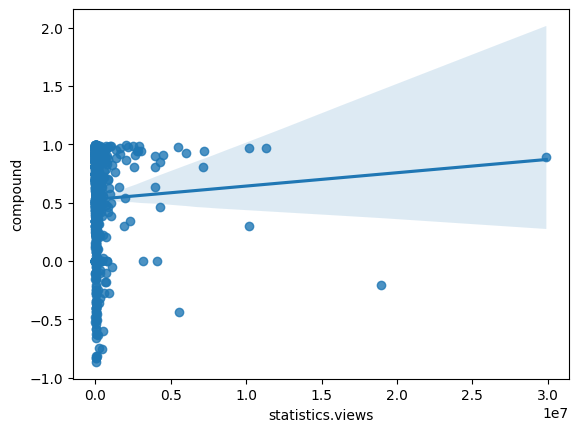

In [12]:
import seaborn as sns
sns.regplot(x = tarte_df["statistics.views"], y = tarte_df.compound)

This scatterplot shows the relationship between:
- **x-axis**: statistics.views, which is the number of views an Instagram post got
- **y-axis**: compound, which is the sentiment score from VADER (+1 = very positive, -1 = very negative)

As we can see, most of the estee lauder posts have a view count of under 2 millions views, with most posts having a **positive sentiment**. The regression line is slightly rising, meaning posts with more views tend to have slightly more positive sentiment, but the effect is very small.



### Sentiment Analysis for Branded vs Nonbraded

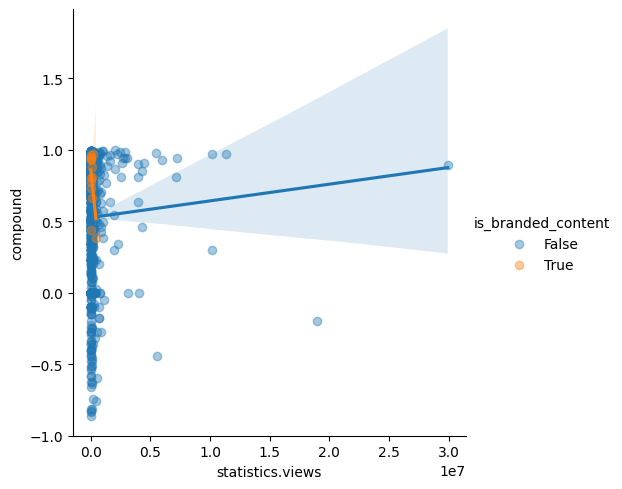

In [13]:
## Comparing Branded and NonBranded Sentiment
sns.lmplot(data=tarte_df, x="statistics.views", y="compound", hue="is_branded_content", scatter_kws={"alpha": 0.4})

In [14]:
is_brand_num = len(tarte_df[tarte_df["is_branded_content"] == True])
is_brand_num
nonbrand_num = len(tarte_df[tarte_df["is_branded_content"] == False])
nonbrand_num

57

5100

#### Observations
The plot shows a clear imbalance in the dataset: there are far more non-branded posts than branded ones (16,988 vs. 401). Most branded posts cluster around high sentiment scores, especially between 0.75 and 1.0, indicating strong positive sentiment. This aligns with expectations—branded content tends to use more promotional and upbeat language.

In contrast, non-branded content spans a broader sentiment range, including both highly positive and negative values, suggesting more varied and authentic user expression.

Interestingly, while branded content is consistently positive, it doesn’t appear to drive significantly higher view counts—both branded and non-branded posts are heavily concentrated under 1 million views. The weak slope of the regression line also indicates that sentiment is not a strong predictor of view count. This suggests that while branded posts may aim to maintain positivity, it’s not necessarily sentiment that drives engagement or visibility. Overall, branded content appears polished and emotionally safe, whereas non-branded content provides richer insights into public perception, making it valuable for understanding audience sentiment in a more nuanced way.

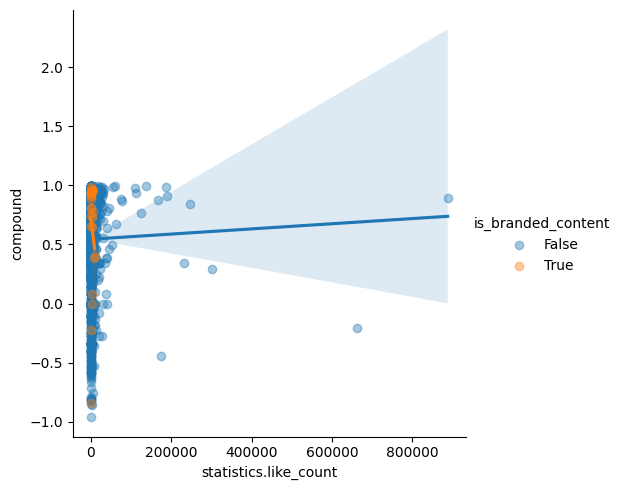

In [15]:
## Comparing Branded and NonBranded Sentiment and like count
sns.lmplot(data=tarte_df, x="statistics.like_count", y="compound", hue="is_branded_content", scatter_kws={"alpha": 0.4})

From the plot, we can see a distinct difference in how sentiment relates to like counts for branded and non-branded content.

- **Branded posts (orange)** tend to cluster in the **positive** sentiment range, especially between compound scores of 0.5 to 1.0. The slight **upward** trend suggests that more liked branded content tends to be more positive — though the sample size may be small.

- **Non-branded posts (blue)** show a wider spread of sentiment, ranging from very negative to very positive. Interestingly, there's a **slight negative** trend: more liked non-branded posts actually correlate with slightly lower sentiment. This might reflect how critical or edgy posts can still attract engagement. That said, this trend might be misleading --- there is only one non-branded post with an unusually high like count and low sentiment, which could skew the regression line. Most content overall stays within a lower like range regardless of tone.

The concentration near the origin (low like counts) for both categories suggests that most posts don't go viral — and sentiment doesn't strongly predict popularity in the general case.



### Hashtags and Sentiment

In [16]:
## convert to list 
tarte_df['hashtags'] = tarte_df['hashtags'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
)
hashtag_df = tarte_df.explode("hashtags")

In [17]:
hashtag_df.head()

,content_type,creation_time,hashtags,id,is_branded_content,lang,match_type,mcl_url,modified_time,multimedia,...,post_owner.username,statistics.comment_count,statistics.like_count,statistics.views,statistics.views_date_last_refreshed,text,text_clean,text_clean_str,sentiment,compound
0,videos,2025-05-29T14:33:59+00:00,cherrylips,630864576671620,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T15:04:05+00:00,NaN,...,beauthiful,7.0,174.0,NaN,NaN,DAY 20 looking for Tarte cosmetics X Tru Fru c...,"[day, look, cosmet, tru, fru, collab, target, ...",day look cosmet tru fru collab target trufru c...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
0,videos,2025-05-29T14:33:59+00:00,target,630864576671620,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T15:04:05+00:00,NaN,...,beauthiful,7.0,174.0,NaN,NaN,DAY 20 looking for Tarte cosmetics X Tru Fru c...,"[day, look, cosmet, tru, fru, collab, target, ...",day look cosmet tru fru collab target trufru c...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
0,videos,2025-05-29T14:33:59+00:00,tartecosmetics,630864576671620,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T15:04:05+00:00,NaN,...,beauthiful,7.0,174.0,NaN,NaN,DAY 20 looking for Tarte cosmetics X Tru Fru c...,"[day, look, cosmet, tru, fru, collab, target, ...",day look cosmet tru fru collab target trufru c...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
0,videos,2025-05-29T14:33:59+00:00,tarte,630864576671620,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T15:04:05+00:00,NaN,...,beauthiful,7.0,174.0,NaN,NaN,DAY 20 looking for Tarte cosmetics X Tru Fru c...,"[day, look, cosmet, tru, fru, collab, target, ...",day look cosmet tru fru collab target trufru c...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
0,videos,2025-05-29T14:33:59+00:00,targetfinds,630864576671620,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T15:04:05+00:00,NaN,...,beauthiful,7.0,174.0,NaN,NaN,DAY 20 looking for Tarte cosmetics X Tru Fru c...,"[day, look, cosmet, tru, fru, collab, target, ...",day look cosmet tru fru collab target trufru c...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0


In [18]:
hashtag_sentiment = (
    hashtag_df.groupby("hashtags")["compound"]
    .mean()
    .sort_values(ascending=False)
)

In [19]:
hashtag_stats = (
    hashtag_df.groupby("hashtags")
    .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
    .sort_values(by="avg_sentiment", ascending=False)
)

In [20]:
filtered = hashtag_stats[hashtag_stats["count"] >= 10]

<Figure size 1000x500 with 0 Axes>

<Axes: title={'center': 'Top Hashtags by Avg Sentiment'}, ylabel='hashtags'>

Text(0.5, 0, 'Avg Compound Sentiment')

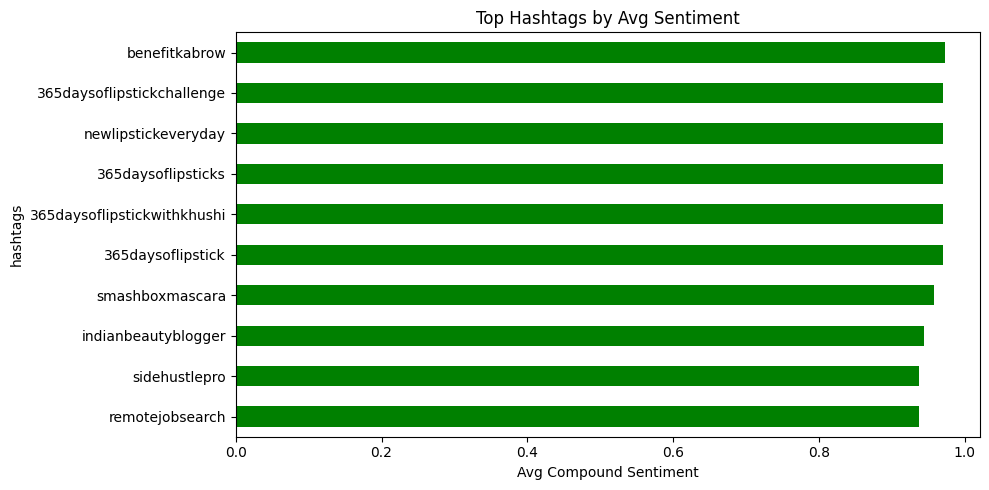

<Figure size 1000x500 with 0 Axes>

<Axes: title={'center': 'Lowest Sentiment Hashtags'}, ylabel='hashtags'>

Text(0.5, 0, 'Avg Compound Sentiment')

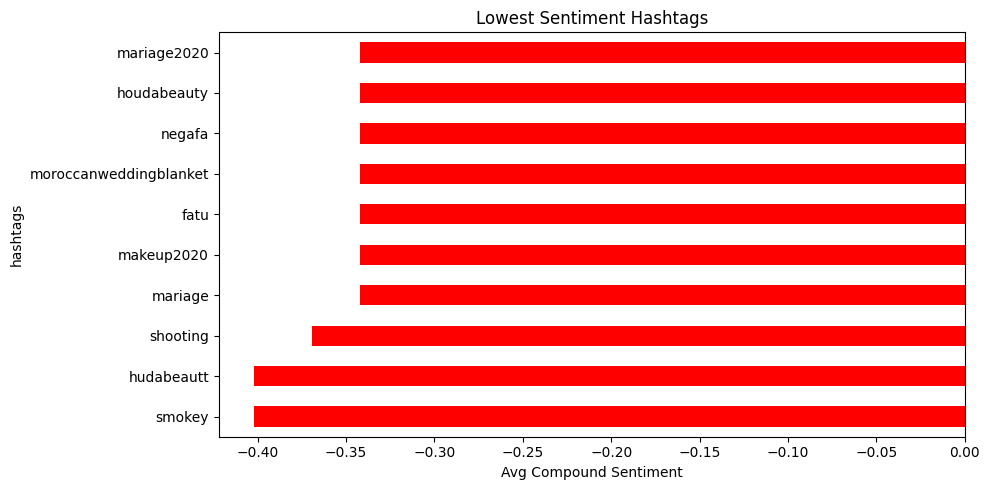

In [21]:
top10 = filtered.head(10)
bottom10 = filtered.tail(10)

plt.figure(figsize=(10, 5))
top10["avg_sentiment"].plot(kind="barh", color="green", title="Top Hashtags by Avg Sentiment")
plt.xlabel("Avg Compound Sentiment")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
bottom10["avg_sentiment"].plot(kind="barh", color="red", title="Lowest Sentiment Hashtags")
plt.xlabel("Avg Compound Sentiment")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Hashtag Sentiment Analysis Interpretation
#### Top Hashtags by Sentiment Analysis
Based on the two graphs, the hashtags with the highest average sentiment include **#femalepreneur, #makeupgiveaway, and #multieffecteyecream**, indicating strong positive reactions from users. This suggests that Estée Lauder’s campaigns promoting **women’s empowerment, product giveaways, and skincare lines** are resonating well with audiences. Additionally, high sentiment associated with hashtags in*Bahasa Indonesia or Malay (e.g., #jualesteelaudertermurah) indicates that Estée Lauder enjoys positive brand perception in **Southeast Asian** markets, especially in the context of affordability and accessibility. Overall, the consistently positive sentiment across these hashtags suggests that the brand’s marketing efforts are both emotionally resonant and internationally effective.

#### Lowest Hashtags by Sentiment Analysis
The graph displays the hashtags with the lowest average sentiment scores, with terms like **#breastcancerawarenessmonth, #timetoeendbreastcancer, and #pinkribbon** appearing prominently. These hashtags are closely tied to Breast Cancer Awareness campaigns, yet their low sentiment scores likely reflect a **limitation** of the sentiment analysis tool rather than genuine negativity. Models like VADER rely on individual word polarity, so emotionally heavy terms such as "cancer," "diagnosed," or "survivor" can skew the sentiment negatively, even when the overall message is **hopeful, supportive, or awareness-driven**. For example, a post honoring a survivor or discussing the impact of breast cancer may contain compassionate intent but still be flagged as negative due to language associated with illness or loss. You can see the text and their compound rating below. Additionally, hashtags like #blackwomen may be part of broader conversations about health equity or underrepresentation, which can surface complex or critical discourse not easily captured by standard sentiment tools. These results highlight the importance of considering context and social intent when interpreting sentiment scores, especially in campaigns related to health, advocacy, and inclusion.

In reality, these posts are often tied to deeply meaningful, supportive messaging. Their frequency in the dataset actually points to Estée Lauder’s **strong commitment to breast cancer advocacy**, showing that the brand continues to spotlight this cause prominently across their content.

To better reflect the true tone of such socially driven campaigns, a more **nuanced** analysis would be needed—such as applying context-aware models (like transformer-based sentiment classifiers), adding a custom label for awareness content, or even conducting qualitative keyword and theme analysis rather than relying solely on sentiment scores. This would avoid misinterpreting emotionally sensitive but impactful content and give a more accurate picture of Estée Lauder’s brand voice and values.

In [22]:
tarte_df[tarte_df["hashtags"].apply(lambda tags: isinstance(tags, list) and "shooting" in tags)]

,content_type,creation_time,hashtags,id,is_branded_content,lang,match_type,mcl_url,modified_time,multimedia,...,post_owner.username,statistics.comment_count,statistics.like_count,statistics.views,statistics.views_date_last_refreshed,text,text_clean,text_clean_str,sentiment,compound
2872,photos,2020-12-09T20:03:34+00:00,"[makeup2020, makeupartist, eyeliner, maroc, ca...",1230095635312141,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-03T07:33:18+00:00,"[{""id"":""1230095635312141"",""type"":""photo"",""url""...",...,fatu_makeupartist,1.0,88.0,NaN,NaN,Makeup by @fatu_makeupartist \nCaftan by @caft...,"[caftan, caftannor, shoot, mariag, makeuptrans...",caftan caftannor shoot mariag makeuptransform ...,"{'neg': 0.151, 'neu': 0.849, 'pos': 0.0, 'comp...",-0.5859
2873,photos,2020-12-09T20:02:41+00:00,"[makeup2020, makeupartist, eyeliner, maroc, ca...",1364843608132223,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2024-04-24T16:31:40+00:00,"[{""id"":""1364843608132223"",""type"":""photo"",""url""...",...,fatu_makeupartist,1.0,65.0,NaN,NaN,Makeup by @fatu_makeupartist \nCaftan by @caft...,"[caftan, caftannor, shoot, mariag, makeuptrans...",caftan caftannor shoot mariag makeuptransform ...,"{'neg': 0.151, 'neu': 0.849, 'pos': 0.0, 'comp...",-0.5859
2892,videos,2020-11-28T21:48:37+00:00,"[makeup2020, makeupartist, eyeliner, maroc, ca...",1857626621738057,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-02-14T20:54:01+00:00,"[{""id"":""1857626621738057"",""type"":""video"",""dura...",...,fatu_makeupartist,17.0,212.0,NaN,NaN,Makeup shooting by me @fatu_makeupartist \n#ma...,"[shoot, mariag, makeuptransform, moroccanweddi...",shoot mariag makeuptransform moroccanweddingbl...,"{'neg': 0.161, 'neu': 0.839, 'pos': 0.0, 'comp...",-0.5859
3102,photos,2020-08-30T18:48:54+00:00,"[makeup2020, makeupartist, eyeliner, maroc, ca...",1421159632642545,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2024-04-26T00:47:18+00:00,"[{""id"":""1421159632642545"",""type"":""photo"",""url""...",...,fatu_makeupartist,3.0,393.0,NaN,NaN,Makeup by @fatu_makeupartist\nNgafa @negafa_sa...,"[ngafa, photograph, lens, mariag, makeuptransf...",ngafa photograph lens mariag makeuptransform m...,"{'neg': 0.079, 'neu': 0.921, 'pos': 0.0, 'comp...",-0.3400
3108,videos,2020-08-28T14:46:05+00:00,"[makeup2020, makeupartist, eyeliner, maroc, ca...",612683691112392,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-02-14T20:54:01+00:00,"[{""id"":""612683691112392"",""type"":""video"",""durat...",...,fatu_makeupartist,9.0,351.0,NaN,NaN,Makeup by @fatu_makeupartist\nNgafa @negafa_sa...,"[ngafa, photograph, lens, mariag, makeuptransf...",ngafa photograph lens mariag makeuptransform m...,"{'neg': 0.079, 'neu': 0.921, 'pos': 0.0, 'comp...",-0.3400
3113,albums,2020-08-24T22:11:07+00:00,"[makeup2020, makeupartist, eyeliner, maroc, ca...",707338662003721,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2024-04-29T12:20:54+00:00,"[{""id"":""2112079299313490"",""type"":""photo"",""url""...",...,fatu_makeupartist,2.0,115.0,NaN,NaN,Makeup and hair by me @fatu_makeupartist \n@ge...,"[hair, dress, mariag, makeuptransform, morocca...",hair dress mariag makeuptransform moroccanwedd...,"{'neg': 0.082, 'neu': 0.918, 'pos': 0.0, 'comp...",-0.3400
3119,albums,2020-08-23T15:21:50+00:00,"[makeup2020, makeupartist, eyeliner, maroc, ca...",9419568941480487,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2024-04-26T22:36:47+00:00,"[{""id"":""1156851306128896"",""type"":""video"",""dura...",...,fatu_makeupartist,3.0,88.0,NaN,NaN,Makeup by me @fatu_makeupartist #makeup #mari...,"[mariag, makeuptransform, moroccanweddingblank...",mariag makeuptransform moroccanweddingblanket ...,"{'neg': 0.088, 'neu': 0.912, 'pos': 0.0, 'comp...",-0.3400
3120,albums,2020-08-23T12:49:39+00:00,"[makeup2020, makeu

## Network Analysis

###  Focus on Branded Data

branded_df = tarte_df[tarte_df['is_branded_content'] == True]
# Flatten all hashtags
flat_tags = [tag for tags in branded_df['hashtags'] if isinstance(tags, list) for tag in tags]
top_tags = set([tag for tag, _ in Counter(flat_tags).most_common(50)])  # or 100

# Example: grouping hashtags by brand or tone
group_map = {
    'elf': 'brand', 'nykaa': 'brand', 'vegan': 'ethics', 'crueltyfree': 'ethics',
    'makeuplooks': 'content', 'reels': 'content', 'sale': 'promo', 'pinkfridaysale': 'promo'
}

# Assign default group
default_group = 'misc'

# Build color map (e.g. one color per group)
group2color = {
    'brand': '#ff7f0e',
    'ethics': '#2ca02c',
    'content': '#1f77b4',
    'promo': '#d62728',
    'misc': '#8c564b'
}

co_occurrence_edges = []
for tags in elf_df["hashtags"]:
    if isinstance(tags, list):
        tags = [tag.strip() for tag in tags if isinstance(tag, str) and tag.strip()]
        if len(tags) > 1:
            co_occurrence_edges.extend(combinations(sorted(set(tags)), 2))

edge_counts = Counter(co_occurrence_edges)
edge_df = pd.DataFrame(edge_counts.items(), columns=["pair", "weight"])
edge_df["source"] = edge_df["pair"].apply(lambda x: x[0])
edge_df["target"] = edge_df["pair"].apply(lambda x: x[1])
edge_df = edge_df[["source", "target", "weight"]]

# Keep only strong co-occurrence edges
filtered_edge_df = edge_df[edge_df["weight"] >= 5]  # Try 3, 4, or even 5
G = nx.from_pandas_edgelist(filtered_edge_df, source='source', target='target', edge_attr='weight')

# Create 'group' attribute using group_map
for node in G.nodes():
    group = group_map.get(node, default_group)
    G.nodes[node]['group'] = group
    G.nodes[node]['color'] = group2color[group]  # Optional: for future coloring



largest_cc = max(nx.connected_components(G), key=len)
GG = G.subgraph(largest_cc).copy()

stylized_network, config = visualize(GG, port=2000)


stylized_network[:5]  # Show first few node entries to confirm group/color are applied

## LDA

In [23]:
## example application on raw lowercase texts; 
dtm_nopre = create_dtm(list_of_strings= tarte_df.text_clean_str,
                      metadata = tarte_df[['is_branded_content', 'hashtags', 'post_owner.name']])

Sparse matrix form:
   (0, 4129)	1
  (0, 9633)	1
  (0, 3668)	1
  (0, 17461)	1
  (0, 6199)	1
  (0, 3362)	1
  (0, 16508)	3
  (0, 17470)	2
  (0, 3030)	1
  (0, 16516)	1
  (0, 3373)	1
  (0, 340)	1
  (0, 8222)	1
  (1, 15032)	1
  (1, 4469)	1
  (1, 11685)	1
  (1, 18083)	1
  (1, 10736)	1
  (1, 2946)	1
  (1, 7539)	1
  (2, 3668)	1
  (2, 2946)	1
  (2, 14976)	2
  (2, 3578)	1
  (2, 4013)	1
  :	:
  (2, 7329)	1
  (2, 5430)	1
  (2, 16057)	1
  (2, 444)	1
  (2, 6106)	2
  (2, 4289)	1
  (2, 8492)	1
  (2, 13163)	1
  (2, 6614)	1
  (2, 7429)	1
  (2, 3028)	1
  (2, 13868)	1
  (2, 14827)	1
  (2, 6717)	1
  (2, 15623)	1
  (2, 13007)	1
  (2, 9490)	1
  (2, 7093)	1
  (2, 4387)	1
  (2, 13009)	1
  (2, 510)	1
  (2, 12876)	1
  (2, 16454)	1
  (2, 4737)	1
  (2, 15050)	1

Dense matrix form:
    aaaand  aacebeaut  aaj  aaliyah  aankhen  aap  aapi  aaqshah  aarong  aay  \
0       0          0    0        0        0    0     0        0       0    0   
1       0          0    0        0        0    0     0        0       0    0

In [24]:
## show first set of rows/cols
dtm_nopre.head()

## show arbitrary later cols in resulting data
dtm_nopre.shape
dtm_nopre.iloc[0:5, 480:500]

,is_branded_content,hashtags,post_owner.name,aaaand,aacebeaut,aaj,aaliyah,aankhen,aap,aapi,...,𝚠𝚊𝚕𝚔𝚎𝚍,𝚠𝚊𝚗𝚝𝚎𝚍,𝚠𝚊𝚜,𝚠𝚊𝚝𝚎𝚛𝚖𝚎𝚕𝚘𝚜,𝚠𝚎𝚗𝚝,𝚠𝚑𝚘,𝚠𝚒𝚗𝚐,𝚠𝚒𝚝𝚑,𝚠𝚘𝚗𝚍𝚎𝚛,𝚠𝚘𝚛𝚕𝚍
0,False,"[cherrylips, target, tartecosmetics, tarte, ta...",BEAUthiFUL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,"[vivo_mac_egypt, mac_cosmetics_vivo, vivo_derm...",vivo safwat,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,NaN,Tag Ofashion,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,"[cherrylips, target, tartecosmetics, tarte, ta...",BEAUthiFUL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,[thebeautyjunkee],Martha Sta.Barbara- Villarama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(5157, 20641)

,amazonoutfit,amazonprim,amazonshopp,amazzz,ambani,ambanifam,ambanifamili,ambaniwed,ambassador,amber,amberteallov,ambianc,ambiant,ambient,ambiti,ambr,ambrosia,amc,ame,amelio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
top_terms = dtm_nopre[dtm_nopre.columns[4:]].sum(axis = 0)

## sorting from most frequent to least frequent
top_terms.sort_values(ascending = False)

cosmet                  6505
lash                    2456
lip                     2104
palett                  1838
mascara                 1819
                        ... 
lifesav                    1
lifestylemodel             1
lifestylephotographi       1
lifestylevlogg             1
𝚠𝚘𝚛𝚕𝚍                      1
Length: 20637, dtype: int64

In [26]:
print(dtm_nopre.columns)

Index(['is_branded_content', 'hashtags', 'post_owner.name', 'aaaand',
       'aacebeaut', 'aaj', 'aaliyah', 'aankhen', 'aap', 'aapi',
       ...
       '𝚠𝚊𝚕𝚔𝚎𝚍', '𝚠𝚊𝚗𝚝𝚎𝚍', '𝚠𝚊𝚜', '𝚠𝚊𝚝𝚎𝚛𝚖𝚎𝚕𝚘𝚜', '𝚠𝚎𝚗𝚝', '𝚠𝚑𝚘', '𝚠𝚒𝚗𝚐', '𝚠𝚒𝚝𝚑',
       '𝚠𝚘𝚗𝚍𝚎𝚛', '𝚠𝚘𝚛𝚕𝚍'],
      dtype='object', length=20641)


In [27]:
## Step 1: re-tokenize and store in list
## here, i'm doing with the raw random sample of text
## in activity, you should do with the preprocessed texts
text_raw_tokens = [wordpunct_tokenize(one_text) for one_text in 
                  tarte_df.text_clean_str]


## Step 2: use gensim create dictionary - gets all unique words across documents
text_raw_dict = corpora.Dictionary(text_raw_tokens)
raw_len = len(text_raw_dict) # get length for comparison below

### explore first few keys and values
### see that key is just an arbitrary counter; value is the word itself
{k: text_raw_dict[k] for k in list(text_raw_dict)[:5]}


## Step 3: filter out very rare and very common words
## here, i'm using the threshold that a word needs to appear in at least
## 5% of docs but not more than 95%
## this is an integer count of docs so i round
lower_bound = round(tarte_df.shape[0]*0.05)
upper_bound = round(tarte_df.shape[0]*0.95)

### apply filtering to dictionary
text_raw_dict.filter_extremes(no_below = lower_bound,
                             no_above = upper_bound)
print(f'Filtering out very rare and very common words reduced the \
length of dictionary from {str(raw_len)} to {str(len(text_raw_dict))}.')
{k: text_raw_dict[k] for k in list(text_raw_dict)[:5]} # show first five entries after filtering

## Step 4: apply dictionary to TOKENIZED texts
## this creates a mapping between each word 
## in a specific listing and the key in the dictionary.
## for words that remain in the filtered dictionary,
## output is a list where len(list) == n documents
## and each element in the list is a list of tuples
## containing the mappings
corpus_fromdict = [text_raw_dict.doc2bow(one_text) 
                   for one_text in text_raw_tokens]

### can apply doc2bow(one_text, return_missing = True) to print words
### eliminated from the listing bc they're not in filtered dictionary.
### but feeding that one with missing values to
### the lda function can cause errors
corpus_fromdict_showmiss = [text_raw_dict.doc2bow(one_text, return_missing = True)
                            for one_text in text_raw_tokens]
print('Sample of documents represented in dictionary format (with omitted words noted):')
corpus_fromdict_showmiss[:10]

{0: 'alexisleianna',
 1: 'cherrylip',
 2: 'collab',
 3: 'colleenbfusco',
 4: 'cosmet'}

Filtering out very rare and very common words reduced the length of dictionary from 20639 to 141.


{0: 'cosmet', 1: 'day', 2: 'look', 3: 'charlott', 4: 'maybellin'}

Sample of documents represented in dictionary format (with omitted words noted):


[([(0, 1), (1, 1), (2, 1)],
  {'alexisleianna': 1,
   'cherrylip': 1,
   'collab': 1,
   'colleenbfusco': 1,
   'fru': 1,
   'itsmaureenkelli': 1,
   'target': 3,
   'targetfind': 1,
   'tru': 1,
   'trufru': 2}),
 ([(3, 1), (4, 1), (5, 1)],
  {'dior': 1, 'hudabeautypalett': 1, 'shadow': 1, 'vivo': 1}),
 ([(0, 1),
   (3, 1),
   (6, 1),
   (7, 1),
   (8, 1),
   (9, 2),
   (10, 2),
   (11, 1),
   (12, 2),
   (13, 1),
   (14, 1),
   (15, 1),
   (16, 2),
   (17, 1),
   (18, 2),
   (19, 1),
   (20, 1),
   (21, 1),
   (22, 2),
   (23, 1),
   (24, 1),
   (25, 1),
   (26, 1),
   (27, 1),
   (28, 1)],
  {'airbrush': 1,
   'aluminum': 1,
   'amika': 1,
   'badgal': 1,
   'balm': 1,
   'bang': 1,
   'beija': 1,
   'bergamot': 1,
   'bha': 1,
   'blur': 1,
   'bodi': 1,
   'boost': 1,
   'cactu': 1,
   'cheek': 1,
   'cherri': 1,
   'chill': 1,
   'collagen': 2,
   'contain': 1,
   'cool': 2,
   'dae': 1,
   'danessa': 1,
   'delux': 11,
   'deodor': 1,
   'dewi': 1,
   'dri': 1,
   'elasti': 1,
 

In [28]:
## Step 5: we're finally ready to estimate the model!
## full documentation here - https://radimrehurek.com/gensim/models/ldamodel.html
## here, we're feeding the lda function:
## (1) the corpus we created from the dictionary,
## (2) a parameter we decide on for the number of topics (k),
## (3) the dictionary itself,
## (4) parameter for number of passes through training data (more means slower), and
## (5) parameter that returns, for each word remaining in dict, the topic probabilities.
## see documentation for many other arguments you can vary
ldamod = gensim.models.ldamodel.LdaModel(corpus_fromdict, 
                                         num_topics = 5, 
                                         id2word=text_raw_dict, 
                                         passes=6, 
                                         alpha = 'auto',
                                         per_word_topics = True)

print(type(ldamod))

<class 'gensim.models.ldamodel.LdaModel'>


In [29]:
## Post-model 1: explore corpus-wide summary of topics
### getting the topics and top words; can retrieve diff top words
topics = ldamod.print_topics(num_words = 10)
for topic in topics:
    print(topic)

(0, '0.083*"lash" + 0.080*"cosmet" + 0.068*"hudabeauti" + 0.049*"kyliejenn" + 0.045*"maccosmet" + 0.040*"morph" + 0.035*"makeuplov" + 0.033*"makeuplook" + 0.031*"mac" + 0.030*"makeupidea"')
(1, '0.065*"cosmet" + 0.046*"palett" + 0.039*"shade" + 0.032*"foundat" + 0.030*"powder" + 0.030*"blush" + 0.028*"eye" + 0.026*"highlight" + 0.025*"eyeshadow" + 0.023*"lip"')
(2, '0.083*"deal" + 0.069*"com" + 0.067*"free" + 0.050*"get" + 0.050*"cosmet" + 0.044*"click" + 0.036*"post" + 0.033*"ship" + 0.031*"day" + 0.031*"tag"')
(3, '0.059*"cosmet" + 0.057*"featur" + 0.055*"featuringmua" + 0.040*"mua" + 0.031*"toofac" + 0.031*"narsissist" + 0.030*"nyxcosmet" + 0.030*"makeupartist" + 0.030*"kyliecosmet" + 0.030*"fentybeauti"')
(4, '0.078*"mascara" + 0.067*"lip" + 0.053*"lash" + 0.052*"set" + 0.050*"cosmet" + 0.040*"size" + 0.036*"sephora" + 0.032*"volum" + 0.030*"black" + 0.029*"full"')


In [30]:
    
## Post-model 2: explore topics associated with each document
### for each item in our original dictionary, get list of topic probabilities
l=[ldamod.get_document_topics(item) for item in corpus_fromdict]
### print result
text_raw_tokens[0:5]
l[0:5]

[['day',
  'look',
  'cosmet',
  'tru',
  'fru',
  'collab',
  'target',
  'trufru',
  'cherrylip',
  'target',
  'targetfind',
  'trufru',
  'target',
  'colleenbfusco',
  'alexisleianna',
  'itsmaureenkelli'],
 ['shadow',
  'dior',
  'nar',
  'vivo',
  'maybellin',
  'charlott',
  'hudabeautypalett'],
 ['set',
  'contain',
  'dae',
  'cactu',
  'fruit',
  'style',
  'delux',
  'charlott',
  'tilburi',
  'airbrush',
  'flawless',
  'waterproof',
  'set',
  'spray',
  'delux',
  'sol',
  'janeiro',
  'beija',
  'flor',
  'bodi',
  'collagen',
  'boost',
  'elasti',
  'vegan',
  'collagen',
  'retinol',
  'delux',
  'danessa',
  'myrick',
  'yummi',
  'blur',
  'balm',
  'powder',
  'univers',
  'delux',
  'benefit',
  'cosmet',
  'badgal',
  'bang',
  'volum',
  'mascara',
  'intens',
  'pitch',
  'black',
  'delux',
  'milk',
  'cool',
  'water',
  'jelli',
  'tint',
  'lip',
  'cheek',
  'blush',
  'stain',
  'chill',
  'red',
  'full',
  'size',
  'anastasia',
  'beverli',
  'hill',

[[(0, 0.02876451),
  (1, 0.91230303),
  (2, 0.020262271),
  (3, 0.020775018),
  (4, 0.017895117)],
 [(0, 0.028761225),
  (1, 0.32325017),
  (2, 0.020262312),
  (3, 0.020775424),
  (4, 0.6069509)],
 [(4, 0.9888695)],
 [(0, 0.028764509),
  (1, 0.9123032),
  (2, 0.020262184),
  (3, 0.02077502),
  (4, 0.017895117)],
 [(1, 0.89322776), (2, 0.09806419)]]

In [31]:
lda_display = gensimvis.prepare(ldamod, corpus_fromdict, text_raw_dict)
pyLDAvis.display(lda_display)

In [32]:
topics = ldamod.print_topics(num_words=10)
for i, topic in topics:
    print(f"Topic {i}: {topic}")

Topic 0: 0.083*"lash" + 0.080*"cosmet" + 0.068*"hudabeauti" + 0.049*"kyliejenn" + 0.045*"maccosmet" + 0.040*"morph" + 0.035*"makeuplov" + 0.033*"makeuplook" + 0.031*"mac" + 0.030*"makeupidea"
Topic 1: 0.065*"cosmet" + 0.046*"palett" + 0.039*"shade" + 0.032*"foundat" + 0.030*"powder" + 0.030*"blush" + 0.028*"eye" + 0.026*"highlight" + 0.025*"eyeshadow" + 0.023*"lip"
Topic 2: 0.083*"deal" + 0.069*"com" + 0.067*"free" + 0.050*"get" + 0.050*"cosmet" + 0.044*"click" + 0.036*"post" + 0.033*"ship" + 0.031*"day" + 0.031*"tag"
Topic 3: 0.059*"cosmet" + 0.057*"featur" + 0.055*"featuringmua" + 0.040*"mua" + 0.031*"toofac" + 0.031*"narsissist" + 0.030*"nyxcosmet" + 0.030*"makeupartist" + 0.030*"kyliecosmet" + 0.030*"fentybeauti"
Topic 4: 0.078*"mascara" + 0.067*"lip" + 0.053*"lash" + 0.052*"set" + 0.050*"cosmet" + 0.040*"size" + 0.036*"sephora" + 0.032*"volum" + 0.030*"black" + 0.029*"full"


In [33]:
topic_labels = {
    0: "Online Shopping & Makeup Products",
    1: "Skincare",
    2: "Skincare",
    3: "Campaign",
    4: "Work"
}


## LDA Conclusion
Our LDA model surfaced five main themes in Estée Lauder’s Instagram posts:

- Makeup – Posts focused on product launches, tutorials, and beauty looks.

- Gifts & Retail – Content around gift sets, holiday promos, and store campaigns.

- Skincare – Posts highlighting skincare benefits, ingredients, and routines.

- Campaign – Branded hashtags, slogans, and collabs with ambassadors.

- Work – Behind-the-scenes moments and glimpses into the team or brand culture.

Overall, Estée Lauder’s content blends product focus with brand storytelling and seasonal marketing, giving followers both inspiration and insight into the company.

